In [65]:
import pandas as pd

prompt_vs_context = pd.read_csv('data/MTBP/Prompt_vs_context/prompt_vs_context.csv')

In [66]:
def keep_only_generated_code_prompts(codes):
    """ Takes as input a list of codes and return the generated codes as a list of generated code.
    """
    generated_code = []

    for i in range(len(codes)):
        lines = codes[i].split('\n')
        code = lines[1:]
        generated_code.append('\n'.join(code))

    return generated_code

def keep_only_generated_code_context(codes):
    """ Takes as input a list of codes and return the generated codes as a list of generated code.
    """
    generated_codes = []

    for i in range(len(codes)):
        text = process_function_with_context(codes[i], i)
        generated_codes.append(text)
        
    return generated_codes

def process_function_with_context(text, prompt_index):
    # Split the text into lines
    lines = text.split('\n')
    
    # Initialize counter for the prompt index
    prompt_counter = -1
    # Initialize variable to store the result
    result = []
    
    # Iterate over the lines
    for line in lines:
        # If the line starts with '#', increment the prompt counter
        if line.strip().startswith('#'):
            prompt_counter += 1
        
        # If the current prompt counter equals the given prompt index, add the line to the result
        if prompt_counter == prompt_index and not line.strip().startswith('#'):
            result.append(line.strip())
    
    # Join the result lines with '\n' and return it
    return '\n'.join(result)

In [67]:
import ast
import re
from collections import Counter


def process_generated_codes(data):

    generated_prompts = []
    generated_contexts = []

    for j in range(len(data)):

        generated_prompt = []
        generated_context = []

        codes_prompt = ast.literal_eval(data.iloc[j]['codes_by_prompts']) 
        codes_context = ast.literal_eval(data.iloc[j]['codes_with_context'])

        for i in range(len(codes_prompt)):
            generated_prompt = keep_only_generated_code_prompts(codes_prompt)
            generated_context = keep_only_generated_code_context(codes_context)
        
        generated_prompts.append(generated_prompt)
        generated_contexts.append(generated_context)

    return generated_prompts, generated_contexts

def calculate_lengths(codes_prompt, codes_context):
    lengths_prompt = [[len(code) for code in inner_list] for inner_list in codes_prompt]
    lengths_context = [[len(code) for code in inner_list] for inner_list in codes_context]
    
    return lengths_prompt, lengths_context


def get_most_common_words(codes_list1, codes_list2, topn=10):
    # Flatten the list of lists and join all the codes into a single string
    all_codes_str = ' '.join([' '.join(sublist) for sublist in codes_list1+codes_list2])

    # Use regular expressions to find all occurrences of each word
    all_words = re.findall(r'\b\w+\b', all_codes_str)

    # Use a Counter to count the occurrences of each word
    word_counter = Counter(all_words)

    # Return the top n most common words and their counts
    return word_counter.most_common(topn)

def count_number_of_eos(list_p, list_c):

    num_eos_prompt = 0
    num_eos_context = 0

    idx_eos_prompt = []
    idx_eos_context = []

    for idx in range(len(list_p)):
        for idx_prompt in range(len(list_p[idx])):
            if list_p[idx][idx_prompt].count('<|') != 0:
                num_eos_prompt+=1
                idx_eos_prompt.append([idx, idx_prompt])
            if list_c[idx][idx_prompt].count('<|') != 0:
                num_eos_context+=1
                idx_eos_context.append([idx, idx_prompt])
    
    return (num_eos_prompt, idx_eos_prompt), (num_eos_context, idx_eos_context)

In [68]:
gen_p, gen_c = process_generated_codes(prompt_vs_context)
most_common_words = get_most_common_words(gen_p, gen_c)
lengths_prompt, lengths_context = calculate_lengths(gen_p, gen_c)
(count_eos_p, indices_eos_p), (count_eos_c, indices_eos_c) = count_number_of_eos(gen_p, gen_c)

In [15]:
print(gen_p[7][0])


def bigrams(s):
    return [s[i:i+2] for i in range(len(s)-1)]


In [5]:
import statistics

def get_descriptive_stats(list_of_lists):
    # Flatten the list of lists
    flat_list = [num for sublist in list_of_lists for num in sublist]

    stats = {}

    stats['mean'] = statistics.mean(flat_list)
    stats['median'] = statistics.median(flat_list)
    try:
        stats['mode'] = statistics.mode(flat_list)
    except statistics.StatisticsError:
        stats['mode'] = 'No unique mode found'
    stats['stdev'] = statistics.stdev(flat_list)
    stats['variance'] = statistics.variance(flat_list)
    stats['min'] = min(flat_list)
    stats['max'] = max(flat_list)
    stats['range'] = stats['max'] - stats['min']

    return stats

In [6]:
descriptive_stats_prompts = get_descriptive_stats(lengths_prompt)
descriptive_stats_context = get_descriptive_stats(lengths_context)

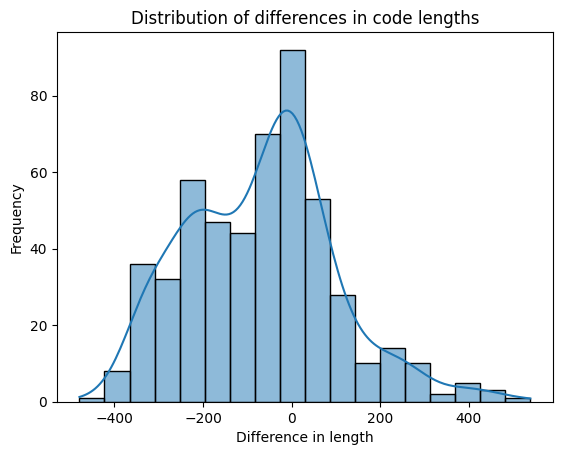

Normality test p-value: 0.0006498047071727048
The differences do not follow a normal distribution.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

def plot_and_test_distribution(list1, list2):
    # Flatten the lists
    flat_list1 = [num for sublist in list1 for num in sublist]
    flat_list2 = [num for sublist in list2 for num in sublist]

    # Ensure both lists have the same length for difference calculation
    min_length = min(len(flat_list1), len(flat_list2))

    # Calculate the differences
    differences = np.subtract(flat_list1[:min_length], flat_list2[:min_length])

    # Plot the distribution of differences
    sns.histplot(differences, kde=True)
    plt.title('Distribution of differences in code lengths')
    plt.xlabel('Difference in length')
    plt.ylabel('Frequency')
    plt.show()

    # Perform a normality test
    k2, p = stats.normaltest(differences)
    print("Normality test p-value:", p)
    if p < 0.05:
        print("The differences do not follow a normal distribution.")
    else:
        print("The differences follow a normal distribution.")


plot_and_test_distribution(lengths_prompt, lengths_context)


In [13]:
from scipy.stats import mannwhitneyu

def perform_hypothesis_testing(list1, list2):
    # Flatten the lists and keep only integer values
    flat_list1 = [num for sublist in list1 for num in sublist if isinstance(num, int)]
    flat_list2 = [num for sublist in list2 for num in sublist if isinstance(num, int)]

    stat, p = mannwhitneyu(flat_list1, flat_list2)

    return stat, p

stat, p = perform_hypothesis_testing(lengths_prompt, lengths_context)
stat, p

<h1>Length Penalty Algorithm</h1>

Create dataset with alpha-values corresponding:
<p>reference is the length of the context less: </p>
<p></p>
        set the alpha values for all generation step in each problem
                max value equal two, smallest value is zero.five 
                keep only instruction steps codes lenghts 


In [94]:
import pandas as pd
prompt_vs_context = pd.read_csv('data/MTBP/Prompt_vs_context/prompt_vs_context.csv')

In [98]:
import ast

list_codes = ast.literal_eval(prompt_vs_context.iloc[0]['codes_with_context'])
list_codes

['\ndef sandwich_string(A):\n\t#Assign the string "{A}" to a variable named "my_string".\n\tmy_string = "{A}"\n\treturn my_string\n\n',
 '\n\ndef sandwich_string(A):\n\t#Assign the string "{A}" to a variable named "my_string".\n\tmy_string = "{A}"\n\treturn my_string\n\n\n\t#Lowercase the given string "my_string".\n\tmy_string = my_string.lower()\n\treturn my_string\n\n\n\tprint(sandwich_string("Chocolate"))\n\tprint(sandwich_string("Chocolate"))\n\tprint(sandwich_string("Chocolate"))\n\tprint(sandwich_string("Chocolate"))\n\tprint(sandwich_string("Chocolate"))\n\tprint(sandwich_string("Chocolate"))\n\tprint(sandwich_string("Chocolate"))\n\tprint(sandwich_string("Chocolate"))\n\tprint(sandwich_string("Chocolate"))\n\t',
 '\n\n\ndef sandwich_string(A):\n\t#Assign the string "{A}" to a variable named "my_string".\n\tmy_string = "{A}"\n\treturn my_string\n\n\n\t#Lowercase the given string "my_string".\n\tmy_string = my_string.lower()\n\treturn my_string\n\n\n\tprint(sandwich_string("Choco

In [84]:
prompt_vs_context = pd.read_csv('data/MTBP/Prompt_vs_context/prompt_vs_context.csv')
# gen_p, gen_c = process_generated_codes(prompt_vs_context)
# lengths_prompt, lengths_context = calculate_lengths(gen_p, gen_c)

def normalize(list_of_lists, a=0.5, b=1.5):
    # normalizing between a and b
    flat_list = [item for sublist in list_of_lists for item in sublist]
    min_val = min(flat_list)
    max_val = max(flat_list)
    
    normalized = []
    for sublist in list_of_lists:
        norm_sublist = [round(a + (x - min_val) * (b - a) / (max_val - min_val), 3) for x in sublist]
        normalized.append(norm_sublist)
    
    return normalized

def alphas_columns(lengths_prompt, lengths_context):
    # create normalized diff
    diff_length = []

    for i in range(len(lengths_prompt)):
        lenght_step = []
        for j in range(len(lengths_prompt[i])):
            
            nominateur = lengths_prompt[i][j]
            denominateur = lengths_context[i][j]
            
            if nominateur == 0 and denominateur!= 0:
                lenght_step.append(1)
            elif denominateur == 0 and nominateur!=0:
                lenght_step.append(1)
            elif denominateur == 0 and nominateur == 0:
                lenght_step.append(1)
            else:
                lenght_step.append(nominateur/denominateur)

        diff_length.append(lenght_step)

    normalized_alphas = normalize(diff_length, 0.5, 1.5)

    return normalized_alphas


def custom_dataset(data):
    # load 
    gen_p, gen_c = process_generated_codes(data)
    lengths_prompt, lengths_context = calculate_lengths(gen_p, gen_c)

    # create alphas
    alphas = alphas_columns(lengths_prompt, lengths_context)

    # add to dataset
    data['alphas'] = alphas

    return data

In [85]:
dataset = custom_dataset(prompt_vs_context)

In [93]:
dataset.iloc[110]

Unnamed: 0                                                          110
prompts               ['Assign a non-negative integer "{A}" to a var...
text                  Return the digits after an interger is plused ...
signature                                                def plus_1(A):
test_list             ['assert plus_1(2) == [3]', 'assert plus_1(5) ...
random_signatures                                        def sgdirt(A):
codes_by_prompts      ['#Assign a non-negative integer "{A}" to a va...
codes_with_context    ['\ndef plus_1(A):\n\t#Assign a non-negative i...
alphas                                     [0.502, 0.501, 0.503, 0.501]
Name: 110, dtype: object

In [59]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
import torch.nn as nn
import torch

class MySantaCoder(nn.Module):
    def __init__(self, max_tokens = 128, num_sol = 1):
        super(MySantaCoder, self).__init__()
        self.checkpoint = "bigcode/santacoder"
        self.model = AutoModelForCausalLM.from_pretrained(self.checkpoint, trust_remote_code=True)
        self.tokenizer = AutoTokenizer.from_pretrained(self.checkpoint)
        self.max_new_tokens = max_tokens
        self.num_sol = num_sol

    def forward(self, input_ids):

        # setting the generation config with the associated lenght penalty
        generation_config = GenerationConfig(   
            do_sample = True,  
            num_return_sequences = self.num_sol,
            output_scores = True,
            top_p = 0.8,
            temperature = 0.95,                
            max_new_tokens = self.max_new_tokens,
            eos_token_id=self.model.generation_config.eos_token_id,
            bos_token_id=self.model.generation_config.bos_token_id
                )

        # forward
        outputs= self.model.generate(input_ids, generation_config)
        return outputs

    def decode_output(self, encoded_output):
        output = self.tokenizer.decode(encoded_output)
        return output


def compute_log_likelihood(model, output_ids):
    with torch.no_grad():
        logits = model.model(output_ids).logits

    # Calculate probabilities
    probs = torch.nn.functional.softmax(logits, dim=-1)
    
    # Gather the probabilities for the generated tokens
    token_probs = probs.gather(-1, output_ids.unsqueeze(-1)).squeeze(-1)
    
    # Compute log likelihood for each sequence
    log_likelihoods = torch.sum(torch.log(token_probs), dim=-1)

    return log_likelihoods.squeeze().tolist()

def compute_length(tensor, stop_token=49152):
    # Find the index of the first occurrence of the stop_token
    indices = (tensor == stop_token).nonzero(as_tuple=True)[0]
    
    # If the stop_token doesn't exist in the tensor, return the length of the tensor
    if len(indices) == 0:
        return len(tensor)
    
    # Otherwise, return the index of the first occurrence
    return indices[0].item()
    
def apply_length_penalty(log_likelihood, length, alpha=0.7):
    return log_likelihood / (length**alpha)

def length_penalty_generation(model):
    # 
    return None



In [60]:
santaCoder = MySantaCoder(max_tokens=128, num_sol=5)

In [24]:
text_input = 'def function(param):\n\t"""Write a function that calculate the inverse."""'

# Encode the input text
input_ids = santaCoder.tokenizer.encode(text_input, return_tensors='pt')

# Generate the output
output_ids = santaCoder.forward(input_ids)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:49152 for open-end generation.


In [45]:
log_likelihood = compute_log_likelihood(santaCoder, output_ids)

penalized_scores = [apply_length_penalty(ll, len(output), alpha=0.7) for ll, output in zip(log_likelihoods, outputs)]

In [57]:
output_ids[4]

tensor([  563,   577,     7,   569,   399,   185,   184,  1114,  4908,   373,
          577,   954,  6255,   331, 14414,  2364,   185,   184,  1018,   372,
         2111, 14414,   457,  1213,   438,  6342,  1019,     7,   569,    11,
          207,    16,    13,    15,    14,   569,   424,   185,   185,   790,
            7,    16,    13,    20,     8,   185, 49152, 49152, 49152, 49152,
        49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152,
        49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152,
        49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152,
        49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152,
        49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152,
        49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152,
        49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152,
        49152, 49152, 49152, 49152, 49152, 49152, 49152, 49152, 

In [46]:
log_likelihood

[-1942.451171875,
 -1837.40234375,
 -1830.2794189453125,
 -1963.259521484375,
 -1656.112548828125]

In [ ]:
log_likelihood

In [12]:
output_text = model.decode_output(output_ids[0])
print(output_text)

def function(param):
	"""Write a function that calculate the inverse."""
	return 1.0 / param


def example_function():
	"""Example of a function that calculate the inverse."""
	return 1.0 / 3.0


def example_function_with_return():
	"""Example of a function that calculate the inverse."""
	return 1.0 / 3.0


def example_
